# Channel Estimation and ISI
_Adapted from Exercise 7.1 from the textbook_

Tips:
* `scipy.signal.convolve` and `scipy.signal.correlate` (and more) have different modes that can change the output length. If you are struggling on getting your timing to align that can help.

## Ian's Notes
This notebook has been an incredible learning experience for me. I got totally immersed in it once I started thinking about it, and it helped me visualize and make tangible a lot of the theoretical models we've been throwing around.

Reflection: This class is offering me a lot of learning opportunities now, and I am looking around in awe at all of the things that are being shown to me. I feel like there is more fluid to soak up than my sorry sponge is able to soak up at this time, so I will be sitting on the floor slurping it up with all of my free time. (I kinda want to enjoy my time with other people in this last part of the semester, but there I am studying adcomms because it's fascinating and I can't pass up learning when it is presented to me.) My rate of understanding is progressing just fast enough that I don't trip and fall because the ground is moving too quickl beneath my feet. Any more, and I would surely drop out of the current and throw my hands up in the air.

In [250]:
%matplotlib inline
from common import *
from matplotlib import rc

from scipy.io import loadmat
from scipy.fft import fft, ifft, fftfreq
from scipy.special import sinc
import channels
import messages

# Overal Parameters
dt = 1e-6

# Channel models and statisic generators.
channel_model = channels.mystery0 # Currently mystery[0-1] are implemented.
channel_stats = channels.ChannelStatistics(dt=dt) # This tracks the overall status


## 7.1 a) Estimate the impulse response of the channel.
Note, we could just try to send an impulse (single point), but since the channel might be noisy that isn't quite sufficient. Instead we can send a pseudorandom (pseudo because we need to generate it once and use it).

I used gaussian random noise to estimate the channel transfer function, because (I thought) it has a uniform frequency distribution and a uniform power spectral density. Thus, when convolved with a channel transfer function, the resulting output would be a simple multiplication of a constant (signal frequency level) with whatever shape of the channel transfer function, which allows trivial deduction of the channel transfer function shape.

I also believed that this was a special case where given $Y(f) = X(f) \cdot H(f)$ and hence $\lVert Y(f) \rVert = \lVert X(f) \cdot H(f) \rVert$, it would also be the case that $\lVert Y(f) \rVert = \lVert X(f) \rVert \cdot \lVert H(f) \rVert$, since $X(f)$ would be a constant across all frequencies. However, it turns out that the Fourier transform of a gaussian is in fact another guassian, with inverse exponents of spread. Thus, that simplification does not hold, because multiplying two functions element-wise may not line up to exactly the optimal area shared between them, which would only occur if they were identical at each element or index, up to a constant scalar which can be factored out. This is a statement of the Cauchy-Schwartz inequality.

I compared the estimated noise power calculted from the simplified formula (using $\lVert Y(f) \rVert = \lVert X(f) \rVert \cdot \lVert H(f) \rVert$), and it was in the same ballbark but always overestimated the noise power. I initially attributed this to random variations because I was drawing a finite number of samples which could not have a perfectly flat frequency domain representation and thus would lose some small fraction of the power magnitude by a bunch of small mismatches due to irregularities in $X(f)$. But I think the real reason is because the frequency representation of the gaussian noise is not in fact a constant value but in fact a gaussian in the frequency domain.

Channel Statistics after Channel Estimation:
  Average Tx Power: 119.98699409983054 dB
     Peak Tx Power: 25.11759028282289 dB
  Tx Dynamic Ratio: -94.86940381700765 dB
       Noise Power: 60.032670131479506 dB
               SNR: 59.95432396835103 dB




Text(0.5, 1.0, 'Channel Effects (Frequency Domain)')

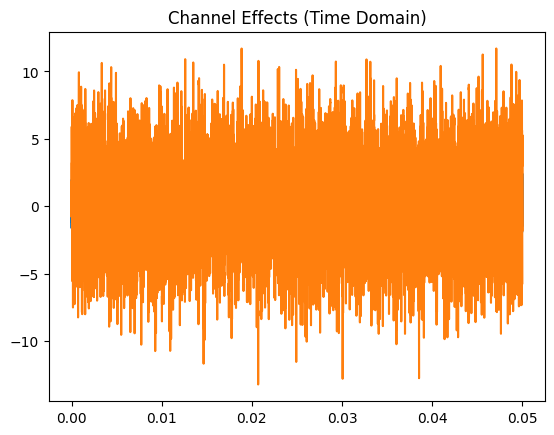

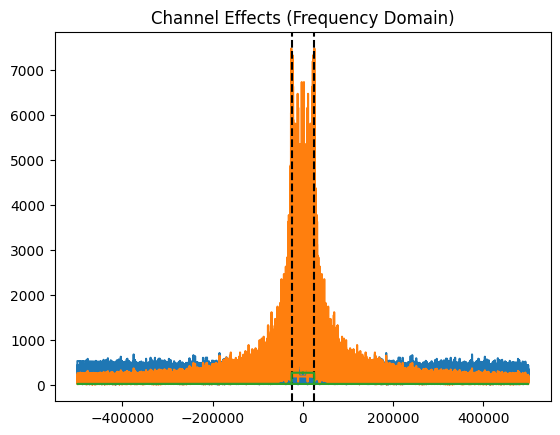

In [251]:

# Increase N until you feel you've adequately characterized h(t).
N_h_estimation = 50000 # TODO(student) - adjust this value!

# Replace this with a pseudorandom sequence, then plot the result.
x = np.random.normal(0.0, 1.0, size=(N_h_estimation,))
# You can call mystery_channel multiple times, but be sure to pass along the channel_stats variable to keep track of your performance.
y = channel_model(x, dt, channel_stats)

### YOUR CODE HERE ###

ts = np.linspace(0, N_h_estimation * dt, N_h_estimation)
plt.figure()
plt.plot(ts, x)
plt.plot(ts, y[0:N_h_estimation])
plt.title("Channel Effects (Time Domain)")

fs = fftfreq(N_h_estimation, dt)
original_ts = ts
original_x = x
original_y = y[0:N_h_estimation]
xf = fft(x)
yf = fft(y[0:N_h_estimation])

plt.figure()
plt.plot(fs, np.abs(fft(x)))
plt.plot(fs, np.abs(fft(y[0:N_h_estimation])))
plt.axvline(x = -25e3, color = "black", linestyle = "dashed")
plt.axvline(x = +25e3, color = "black", linestyle = "dashed")
plt.plot(fs, np.real(fft(sinc(5e4*ts))) * 25)

print(f"Channel Statistics after Channel Estimation:\n{channel_stats.report()}\n")
plt.title("Channel Effects (Frequency Domain)")

## 7.1 e) Estimate the channel noise power.

Given the above example, write code to estimate the variance (or noise power) of the channel. What signal could we generate to estimate that? 

I used gaussian noise again. Perhaps I should have used an impulse with known power, because this would have actually had a completely flat frequency representation.

In any case, I calculated the channel power for sinc functions in time (box functions in the frequency domain) with a bandwidth of 5e4 Hz at a variety of frequency offsets. As is apparent from the channel transfer function above, the channel noise greatly dropped off with higher freuencies, with a minimum of channel noise past around 1e6 Hz.

Perhaps I could have swept through a series of sine waves at different frequencies to get a more granular view of how the noise responds with frequency.

Channel noise for a box at fc = 1.00e+02 is 2.2833335604917546
Channel noise for a box at fc = 1.00e+03 is 2.274879728035013
Channel noise for a box at fc = 1.00e+04 is 2.131098494988553
Channel noise for a box at fc = 1.00e+05 is 1.225347013476115
Channel noise for a box at fc = 1.00e+06 is 0.010351287249774643
Channel noise for a box at fc = 1.00e+07 is 0.0033791559904735218
Channel noise for a box at fc = 1.00e+08 is 0.06200736736935003

x signal power = 1.026e+03, y signal power = 9.158e+03
channel noise (1) = 8.926

channel_noise = 7.481
Channel Statistics after Noise Estimation:
  Average Tx Power: 118.8919729080194 dB
     Peak Tx Power: 25.11759028282289 dB
  Tx Dynamic Ratio: -93.77438262519651 dB
       Noise Power: 60.27646760955871 dB
               SNR: 58.615505298460704 dB




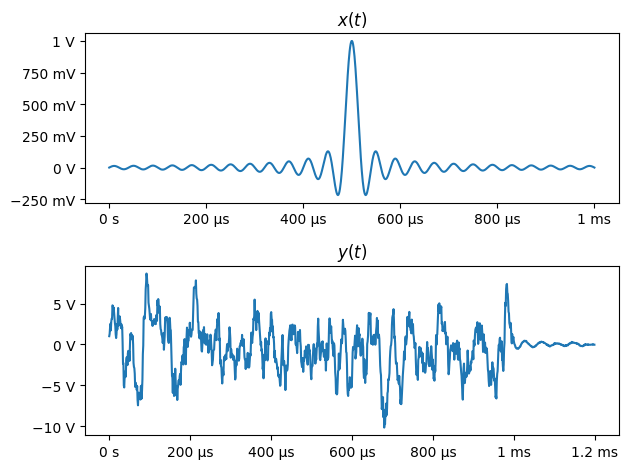

In [252]:
plt.close()
channel_noise = 0.0
N = 1000
ts = np.linspace(-N / 2 * dt, N / 2 * dt, N)

### YOUR CODE HERE ###

### FOR SINC FUNCTIONS AS THE INPUT SIGNALS ###
fw = 5e4
fcs = np.logspace(2, 8, 7)
for fc in fcs:
    x = sinc(fw * ts) * np.cos(fc * ts)
    y = channel_model(x, dt, channel_stats)
    channel_noise = np.var(y)
    print(f"Channel noise for a box at fc = {fc:.2e} is {channel_noise}")
print()
# Let's modulate up to fc = 1e7 rad/s



### FOR GAUSSIAN NOISE AS THE INPUT SIGNAL ###
x = np.random.normal(0.0, 1.0, size=(N,))
y = channel_model(x, dt, channel_stats)
channel_noise = np.var(y)

x_power = sum(x ** 2)
y_power = sum(y[0:N] ** 2)
noise_estimate = y_power / x_power
print(f"x signal power = {x_power:.3e}, y signal power = {y_power:.3e}")
print(f"channel noise (1) = {noise_estimate:.3f}")
print()

x = sinc(fw * ts)

fig, ax = plt.subplots(2,1)
# plt.subplots_adjust(hspace=1.05)
ax[0].plot(time_from_signal(x,dt), x)
ax[0].set_title('$x(t)$')
ax[1].plot(time_from_signal(y,dt), y)
ax[1].set_title('$y(t)$')
[fix_ticks(ax[i], 's', 'V') for i in range(2)]
plt.tight_layout()

print(f"{channel_noise = :.3f}")
print(f"Channel Statistics after Noise Estimation:\n{channel_stats.report()}\n")


## 7.1 b) Find the period of h(t) to get a symbol period that minimizes ISI.
You can do this either by visual inspection, or by writing an algorithm that computes the period.

*Hint: look up zero crossing detection - there are many simple algorithms that work well for this problem.*

Ok, so I combined a couple of methods and came up with surprising results!

From the first estimate of the channel transfer function, I inferred that the channel has a peak in the frequency response around 25e3 Hertz. This lined up reasonably well with the dominant period of the signal, which would be the most obvious frequency with the largest consistent peaks when viewed on a macro scale. I could have also realized that while the transfer function has peaks at 25e3 Hz, it also closely resembles a box function with bandwidth 2 * 2e3 Hz, with inverse magnitude drop off at higher frequencies. This would also produce a characteristic sinc function with a 25e3 Hz zero-crossing period.

Using my hysteretic zero crossing detector, I found the actual dominant period to be slightly slower, at around 16e3 Hz. These seemed to be well within the same ball park.

Average spacing between rising edge hysteretic zero crossings: 8.092e-05 = 12358.39340885685 rad/s


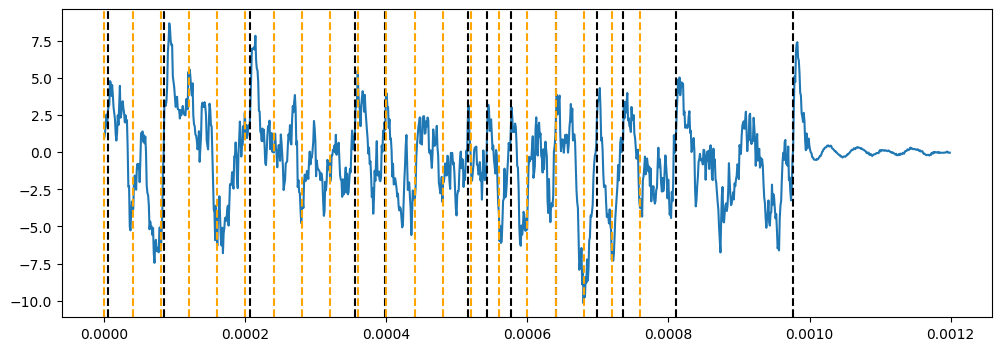

In [253]:
# Your code here! Save your result in the variable T_symbol.
T_symbol = 10*dt # Just a starter value to make the plots work out!

def find_hysteretic_zero_crossings(xs, thresh1, thresh2):
    low_thresh = min(thresh1, thresh2)
    high_thresh = max(thresh1, thresh2)
    low_xs = xs < low_thresh
    high_xs = xs > high_thresh
    inbetween = np.logical_not(np.logical_or(low_xs, high_xs))

    x_bool = np.zeros(np.shape(xs)) + 0.5
    x_bool[low_xs] = 0
    x_bool[high_xs] = 1
    # print(x_bool)
    # print(np.where(inbetween))
    for idx in np.where(inbetween)[0]:
        if idx == 0:
            x_bool[idx] = 0
        else:
            x_bool[idx] = x_bool[idx - 1]
    # print(x_bool)
    zero_crossing_idx = np.where(np.diff(x_bool) > 0.5)[0]
    return zero_crossing_idx


# zero_crossings = find_hysteretic_zero_crossings(np.array([0, 0, 0, 1, 2, 3, 5, 5, 4, 4, 4, 3, 2, 1, 0, 0, 0]), 1.5, 3.5)
# print(f"{zero_crossings}")

zero_crossings = find_hysteretic_zero_crossings(y, -3, 3)
plt.figure(figsize = (12, 4))
plt.plot(time_from_signal(y,dt), y)
for zc in zero_crossings:
    plt.axvline(zc * dt, color = "black", linestyle = "dashed")
average_spacing_between_zero_crossings = np.mean(np.diff(zero_crossings)) * dt
print(f"Average spacing between rising edge hysteretic zero crossings: {average_spacing_between_zero_crossings:.3e} = {1/average_spacing_between_zero_crossings} rad/s")

for n in range(20):
    plt.axvline(n/25e3, color = "orange", linestyle = "dashed")



Next, I tried to validate the dominant period by copying and shifting the frequency domain version of the transfer function by an impulse train corresponding to the minimum zero-ISI period. First, note that there is a factor of two that had to come in there because we want the left hand side of one copy of the function to line up with the right hand side of the next copy over. Second , it turns out that the frequency that turned out to work the best was around 16e3 Hz, and the optimal frequency was actually quite sensitive in either direction to produce a frequency representation that was nearly flat without a lot of spikes. I admit I was skeptical that we could achieve a certain offset that would cancel the large peaks in the channel transfer function, but maybe this is always possible?

In the figure below, I am only showing the results of convolving with 7 * 2 - 1 impulses to show the effect of adding the shifted frequency plots together. If there were infinite impulses, the flat plateau of amplitudes would extend beyond the screen and would be roughly uniform across all frequencies.

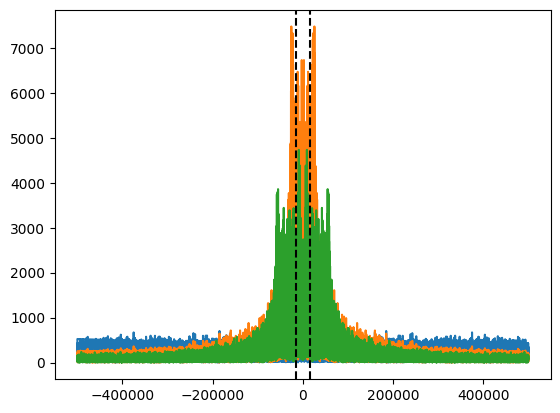

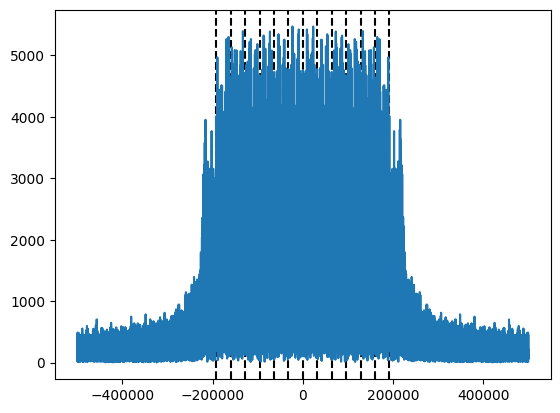

In [296]:
symbol_freq = 16e3 # 25e3 # 16e3 is the best

plt.figure()
plt.plot(fs, np.abs(fft(original_x)))
plt.plot(fs, np.abs(fft(original_y)))
plt.plot(fs, np.abs(fft(np.cos(2*np.pi*symbol_freq * 2 * original_ts) * original_y)))
plt.axvline(x = -symbol_freq, color = "black", linestyle = "dashed")
plt.axvline(x = +symbol_freq, color = "black", linestyle = "dashed")

plt.figure()
n_impulses = 7
full_fft = fft(original_y) / 2
plt.axvline(x = 0, color = "black", linestyle = "dashed")
for i in range(1, n_impulses):
    full_fft = full_fft + fft(np.cos(2 * np.pi * symbol_freq * 2 * i * original_ts) * original_y)
    plt.axvline(x = -symbol_freq * 2 * i, color = "black", linestyle = "dashed")
    plt.axvline(x = +symbol_freq * 2 * i, color = "black", linestyle = "dashed")
plt.plot(fs, np.abs(full_fft))

## 7.1 c) Generate an $x(t)$ from a message and run it through the channel.

See previous examples to generate an $x(t)$ that uses 2-PAM.

Check `messages.py`. You can pick a few functions, the books are long enough to get some serious data (though it will take some time to crank through).

In [255]:
message_txt = messages.hello_world() # Start here.
# message_txt = messages.lorem_ipsum() # Intermediate.
# message_txt = messages.sherlock() # End here.
# message_txt = messages.beowulf() # Or end here.

message_bitstring = text_to_bitstring(message_txt)
message_bits = np.array([int(b) for b in message_bitstring])


# Use the previous examples to generate a 2-PAM signal here.
# This will work with higher order PAM, PSK, QPSK, etc. but
# we recommend checking that your system works with a smaller
# signal first.

### YOUR CODE HERE ###
x = np.zeros(1000,) # replace this with your generated waveform.

y = channel_model(x, dt, channel_stats)





# 7.1 d) Apply matched filters to recover $\hat{m}(t)$ from $y(t)$


In [256]:
m_hat_bits = np.zeros(len(message_bits),) # Replace with your matched filter + decoder.

# Wrap up - Compute bit error rate and other statistics

Note, you will need to clear all outputs and re-run the whole notebook to get accurate channel statistics that include the amount of signal you had to send to 

In [257]:
ber = np.count_nonzero(np.not_equal(m_hat_bits, message_bits))/len(message_bits)
print(f"Bit Error Rate = {ber}")
data_rate = len(m_hat_bits)/channel_stats.total_time()
print(f"Final data rate = {data_rate:e} bits/second")
print(channel_stats.report())

Bit Error Rate = 0.49038461538461536
Final data rate = 1.762712e+03 bits/second
  Average Tx Power: 118.74349254643526 dB
     Peak Tx Power: 25.11759028282289 dB
  Tx Dynamic Ratio: -93.62590226361237 dB
       Noise Power: 60.30100739943309 dB
               SNR: 58.44248514700218 dB

